
<img src="AW&H2015.tiff" style="float: left">    

<img src="flopylogo.png" style="float: center">     


#         Problem P5.3 Industrial Pond Leakage

In Problem P5.3 from pages 246-247 in Anderson, Woessner and Hunt (2015), we are asked to construct an areal 2D model to represent an industrial facility in an arid setting.  It is disposing of fluids in a 900 m by 900 m pond that is leaking at a rate of 0.2 m/d (Fig. P5.2). Recharge from precipitation in this area is negligible. The pond is located in the center of the horizontal problem domain and is underlain by a sequence of sediment layers consisting of sand, clay, and sand and gravel. Wet areas around the pond perimeter at the land surface are causing some local water-logging of the soils and impacting vegetation. The owners of the pond believe that the water-logging is caused by seepage out of the pond through the berms around the sides of the pond. The state regulatory agency, however, suspects that leakage through the bottom of the pond has created a water table mound that intersects the land surface. The objective of modeling is to determine whether the groundwater mound beneath the pond reaches the land surface and is water-logging the soil.

## Part a. 
The consulting firm hired by the industrial facility recommends a 2D areal steady-state unconfined model as a quick and easy way to address the modeling objective. As a newly hired hydrogeologist of the consulting firm, you are
instructed to construct the model. The width of the problem domain is 11,700 m. Use no flow boundary conditions at the north and south ends of the problem domain and specified heads along the sides (Fig. P5.2). Use a uniform nodal spacing of 900 m. Use Eqns (B5.3.2) and (B5.3.3) in Box 5.3 to compute the average horizontal and vertical hydraulic conductivity for the layer. Although the vertical hydraulic conductivity is not used in a one-layer 2D areal model, the vertical anisotropy ratio of the layer is of interest. Produce a contour map of the water table (use 1-m contour intervals) using the computed heads. Under this representation does the water table intersect the land surface?

<img src="P5.3_figure.tiff" style="float: center">

Below is an iPython Notebook that builds a Python MODFLOW model for this problem and plots results. See the Github wiki associated with this Chapter for information on one suggested installation and setup configuration for Python and iPython Notebook.

[Acknowledgements: This tutorial was created by Randy Hunt and all failings are mine.  The exercise here has benefited greatly from the online Flopy tutorial and example notebooks developed by Chris Langevin and Joe Hughes for the USGS Spring 2015 Python Training course GW1774]

## Creating the Model
In this example, we will create a simple groundwater flow modelusing the Flopy website approach. Visit the tutorial website [here](http://modflowpy.github.io/flopydoc/tutorial1.html "tutorial").

### Setup the Notebook Environment and Import Flopy
Load a few standard libraries, and then load flopy.

In [1]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
from subprocess import check_output

# Import flopy
import flopy

### Setup a New Directory and Change Paths
For this tutorial, we will work in a new subdirectory underneath the directory where the notebook is located. We can use some fancy Python tools to help us manage the directory creation. Note that if you encounter path problems with this workbook, you can stop and then restart the kernel and the paths will be reset.

In [2]:
# Set the name of the path to the model working directory
dirname = "P5-3_Industrial_pond"
datapath = os.getcwd()
modelpath = os.path.join(datapath, dirname)
print 'Name of model path: ', modelpath

# Now let's check if this directory exists.  If not, then we will create it.
if os.path.exists(modelpath):
    print 'Model working directory already exists.'
else:
    print 'Creating model working directory.'
    os.mkdir(modelpath)

Name of model path:  /Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-3_Industrial_pond
Creating model working directory.


### Define the Model Extent, Grid Resolution, and Characteristics
It is normally good practice to group things that you might want to change into a single code block.  This makes it easier to make changes and rerun the code.

In [3]:
# model domain and grid definition
# for clarity, user entered variables are typically all caps except for layer thickness (b) and K direction (Kh or Kv); python syntax are lower case or mixed case
# This is an unconfined areal 2D model.
LX = 13500.  # aquifer width of 11700 m + 2 900m nodes for constant head boundary condition on each end
LY = 9000.   # height of aquifer of 9000 m, no flow boundaries do not require explicit cells in MODFLOW
ZTOP = 130.  # the system is unconfined 
ZBOT = 0.
NLAY = 1
NROW = 10
NCOL = 15
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
DELV = (ZTOP - ZBOT) / NLAY
BOTM = np.linspace(ZTOP, ZBOT, NLAY + 1)
# RCH = 0.0    #not needed for Problem P5.3
# WELLQ = 0.   #not needed for Problem P5.3
POND_SEEP=0.2
print "DELR =", DELR, "  DELC =", DELC, '  DELV =', DELV
print "BOTM =", BOTM
#print "Recharge =", RCH 
print "Pond Seepage =", POND_SEEP, "m/d"
#print "Pumping well rate =", WELLQ


DELR = 900.0   DELC = 900.0   DELV = 130.0
BOTM = [ 130.    0.]
Pond Seepage = 0.2 m/d


In this problem we are required to calculate the equivalent 1-layer hydraulic conductivity from the 3-layer system showed in Figure P5.2 using the correct equation from Box 5.3 (equation B5.3.2)

In [4]:
LAY1b=((120.-80)+(90-80))/2   #this calcultes the average saturated thickness of Layer 1
print "The average Layer 1 thickness =", LAY1b, "m"

The average Layer 1 thickness = 25.0 m


This agrees with the value given in the caption in figure P5.2

In [5]:
LAY2b = 80.-40
LAY3b = 40.-0
print "Layer 2 thickness =", LAY2b, "m"
print "Layer 3 thickness =", LAY3b, "m"

Layer 2 thickness = 40.0 m
Layer 3 thickness = 40.0 m


In [6]:
#In equation B5.3.2 we also need the total thickess of the aquifer B
TOT_THICK = LAY1b+LAY2b+LAY3b
print "The total aquifer thickness B =", TOT_THICK, "m"

The total aquifer thickness B = 105.0 m


In [7]:
#Now we can assign the Kh for each layer from Figure P5.2
LAY1Kh=44.
LAY2Kh=0.13
LAY3Kh=113.
#now we can calculate the equivalent Kh from Box 5.3's equation B5.3.2
EQUIV_Kh=(LAY1Kh*LAY1b/TOT_THICK)+(LAY2Kh*LAY2b/TOT_THICK)+(LAY3Kh*LAY3b/TOT_THICK)
print "The 1-layer equivlant Kh =", EQUIV_Kh, "m/d"

The 1-layer equivlant Kh = 53.5733333333 m/d


Don't forget that we are asked to do a similar calculation for equivalent Kv.  I will leave that for you to calculate because it is not needed for a 1-layer MODFLOW model.

### Create the MODFLOW Model Object
Create a flopy MODFLOW object: [flopy.modflow.Modflow](http://modflowpy.github.io/flopydoc/mf.html).

In [8]:
# Assign name and create modflow model object
modelname = 'P5-3'
#exe_name = os.path.join(datapath, 'mf2005.exe') # for Windows OS
exe_name = os.path.join(datapath, 'mf2005')     # for Mac OS
print 'Model executable: ', exe_name
MF = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws=modelpath)

Model executable:  /Users/rjhunt1/GitHub/Chapter_5_problems-1/mf2005


### Discretization Package
Create a flopy discretization package object: [flopy.modflow.ModflowDis](http://modflowpy.github.io/flopydoc/mfdis.html).

In [9]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)

In [10]:
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM[1:], laycbd=0)
# print DIS_PACKAGE  #uncomment this on far left to see information about the flopy object

### Basic Package
Create a flopy basic package object: [flopy.modflow.ModflowBas](http://modflowpy.github.io/flopydoc/mfbas.html).

In [11]:
# Variables for the BAS package
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int32)  # all nodes are active (IBOUND = 1)

# make the top of the profile specified head by setting the IBOUND = -1
IBOUND[:, :, 0] = -1  #don't forget arrays are zero-based! Sets first column
IBOUND[:, :, -1] = -1  # Sets last column
print IBOUND

[[[-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]]]


In [12]:
STRT = 130 * np.ones((NLAY, NROW, NCOL), dtype=np.float32)  # set starting head to landsurface (130 m) throughout model domain
STRT[:, :, 0] = 90.       # leftmost constant head
STRT[:, :, -1] = 120.     # rightmost constant head
print STRT

[[[  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]]]


In [13]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object

### Layer Property Flow Package
Create a flopy layer property flow package object: [flopy.modflow.ModflowLpf](http://modflowpy.github.io/flopydoc/mflpf.html).

In [14]:
LPF_PACKAGE = flopy.modflow.ModflowLpf(MF, laytyp=1, hk=EQUIV_Kh)  # we defined the K and anisotropy at top of file
# print LPF_PACKAGE  # uncomment this at far left to see the information about the flopy LPF object

### Well Package
This is not needed for Problem P5.3

In [15]:
#WEL_PACKAGE = flopy.modflow.ModflowWel(MF, stress_period_data=[0,0,0,WELLQ])  # remember python 0 index, layer 0 = layer 1 in MF
#print WEL_PACKAGE  # uncomment this at far left to see the information about the flopy WEL object

### Output Control
Create a flopy output control object: [flopy.modflow.ModflowOc](http://modflowpy.github.io/flopydoc/mfoc.html).

In [16]:
OC_PACKAGE = flopy.modflow.ModflowOc(MF)   # we'll use the defaults for the model output
# print OC_PACKAGE  # uncomment this at far left to see the information about the flopy OC object

### Preconditioned Conjugate Gradient Solver
Create a flopy pcg package object: [flopy.modflow.ModflowPcg](http://modflowpy.github.io/flopydoc/mfpcg.html).

In [17]:
PCG_PACKAGE = flopy.modflow.ModflowPcg(MF, mxiter=500, iter1=100, hclose=1e-04, rclose=1e-03, relax=0.98, damp=0.5) 
# print PCG_PACKAGE  # uncomment this at far left to see the information about the flopy PCG object

### Recharge Package
Because the pond seepage is given as a flux over the cell (L/T) rather than a volumetric flow rate (L3/T), the Recharge Package is the easier to use than MODFLOW's Well Package.  However, we only want to add pond seepage to the cells that represent the pond.  Therefore, we'll need to make an array like we do for starting heads.

In [18]:
SEEP_ARRAY = 0 * np.ones((NROW, NCOL), dtype=np.float32)  # set seepage to 0 over model grid
SEEP_ARRAY[4, 7] = POND_SEEP  # add Pond seepage at the pond location     
print SEEP_ARRAY


[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.2  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]


Create a flopy pcg package object: [flopy.modflow.ModflowRch](http://modflowpy.github.io/flopydoc/mfrch.html).

In [19]:
RCH_PACKAGE = flopy.modflow.ModflowRch(MF, rech=SEEP_ARRAY)
# print RCH_PACKAGE  # uncomment this at far left to see the information about the flopy RCH object

## Writing the MODFLOW Input Files
Before we create the model input datasets, we can do some directory cleanup to make sure that we don't accidently use old files.

In [20]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print modelpath
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print modelfiles

/Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-3_Industrial_pond
[]


In [21]:
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

In [22]:
#Now write the model input files
MF.write_input()

The model datasets are written using a single command (mf.write_input).

Check in the model working directory and verify that the input files have been created.  Or if you might just add another cell, right after this one, that prints a list of all the files in our model directory.  The path we are working in is returned from this next block.

In [23]:
# return current working directory
print "You can check the newly created files in", modelpath


You can check the newly created files in /Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-3_Industrial_pond


## Running the Model

Flopy has several methods attached to the model object that can be used to run the model.  They are run_model, run_model2, and run_model3.  Here we use run_model3, which will write output to the notebook.

In [24]:
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_5_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P5-3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 15:37:47

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 15:37:47
 Elapsed run time:  0.005 Seconds

  Normal termination of simulation


## Post Processing the Results
To read heads from the MODFLOW binary output file, we can use the [flopy.utils.binaryfile](http://modflowpy.github.io/flopydoc/binaryfile.html) module. Specifically, we can use the HeadFile object from that module to extract head data arrays. 

In [25]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

Headfile (P5-3.hds) contains the following list of times:  [1.0]


In [26]:
#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Head statistics
  min:  90.0
  max:  124.039
  std:  9.71958


Land surface elevation = 130 m, which is significantly higher than the maximum head in the model.

Contour Levels:  [  90.   91.   92.   93.   94.   95.   96.   97.   98.   99.  100.  101.
  102.  103.  104.  105.  106.  107.  108.  109.  110.  111.  112.  113.
  114.  115.  116.  117.  118.  119.  120.  121.  122.  123.  124.  125.]
Extent of domain:  (450.0, 13050.0, 450.0, 8550.0)


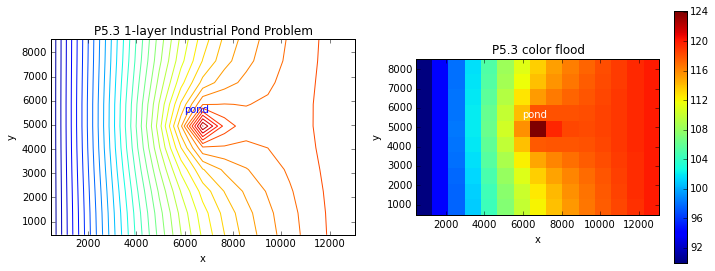

In [27]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(12,10))

#setup contour levels and plot extent
LEVELS = np.arange(90., 126., 1.)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 9000, 1000)
AX1.set_yticks(YTICKS)
AX1.set_title("P5.3 1-layer Industrial Pond Problem")
AX1.text(6000, 5500, r"pond", fontsize=10, color="blue")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("P5.3 color flood")
AX2.text(6000, 5500, r"pond", fontsize=10, color="white")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)


In [28]:
#Using code from P4.4, let's plot a cross section of head in row = 4 from headobj, recall that Python is zero based
#so that MODFLOW row 5 with the pond is equal to Python row 4
#define Y as HEAD along the row and then print; ROW is a variable that allows us to change the row plotted easily
ROW = 4
Y = HEAD[0,ROW,:]
print Y

[  90.           94.19285583   98.24380493  102.22425842  106.24703979
  110.55152893  115.783638    124.03881073  119.60896301  118.41397095
  118.27294159  118.53164673  118.96114349  119.46637726  120.        ]


In [29]:
#in order to plot the cross section we'll need to create X-coordinates to match with heads at the node centers
XCOORD = np.arange(0, 13500, 900) + 450
print XCOORD

[  450  1350  2250  3150  4050  4950  5850  6750  7650  8550  9450 10350
 11250 12150 13050]


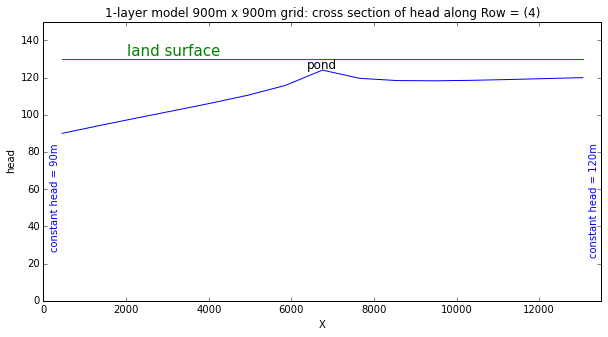

In [30]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  '1-layer model 900m x 900m grid: cross section of head along Row = ({0})'.format(ROW) #this allows the title to be updated as ROW changes
ax.set_title(TITLE)
ax.set_xlabel('X')
ax.set_ylabel('head')
ax.set_xlim(0, 13500.)
ax.set_ylim(0.,150.)
ax.text(6400,125, r"pond", fontsize=12, color="black")
ax.text(2030,132, r"land surface", fontsize=15, color="green")
ax.text(13200, 80, r"constant head = 120m", fontsize=10, color="blue",rotation='vertical')
ax.text(150, 80, r"constant head = 90m", fontsize=10, color="blue",rotation='vertical')
ax.plot(XCOORD, Y)
ax.plot(XCOORD, XCOORD*0+130) #land surface

## P5.3b
The state regulatory agency insists that a 3D model be developed to examine how vertical flow and anisotropy influence the height of the groundwater mound. They point out that the low hydraulic conductivity of layer 2 andthe vertical anisotropy present in the layered sequence of units might cause the mound to rise to the surface. Construct a three- layer steady-state model based on the information in Fig. P5.2. Specified head and no flow boundaries
extend to all layers. Generate an equipotential surface (using 1-m contour intervals) for each layer. Also show the head distribution in a cross section that passes through the specified head boundaries and the pond. 

In [31]:
#we have to redefine the layering 
ZTOP = 130.  # the system is unconfined so set the top above land surface so that the water table never > layer top
ZBOT = 0.
NLAY = 3
BOTM = np.zeros((NLAY, NROW, NCOL), dtype=np.float)
BOTM[0,:,:] = 80.
BOTM[1,:,:] = 40.
BOTM[2,:,:] = 0.
print BOTM

[[[ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.
    80.]
  [ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.
    80.]
  [ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.
    80.]
  [ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.
    80.]
  [ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.
    80.]
  [ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.
    80.]
  [ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.
    80.]
  [ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.
    80.]
  [ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.
    80.]
  [ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  80.
    80.]]

 [[ 40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.
    40.]
  [ 40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.
    40.]
  [ 40.  40.  

In [32]:
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM, laycbd=0)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


Now we must do the same for MODFLOW's Basic Package

In [33]:
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int)
IBOUND[:,:,0] = -1
IBOUND[:,:,-1] = -1
print IBOUND

[[[-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]]

 [[-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]]

 [[-1  1  1  1  

In [34]:
STRT = 130. * np.ones((NLAY, NROW, NCOL), dtype=np.float)
STRT[:,:,0] = 90.
STRT[:,:,-1] = 120.
print STRT

[[[  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]
  [  90.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.  130.
    130.  130.  120.]]

 [[  90.  130.  130.  130.  

In [35]:
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...


Now we must do the same for hydraulic conductivity.

In [36]:
#Now we can assign the Kh for each layer from Figure P5.2
LAY1Kh=44.
LAY2Kh=0.13
LAY3Kh=113.

KH_ARRAY = np.zeros((NLAY, NROW, NCOL), dtype=np.float)
KH_ARRAY[0,:,:] = LAY1Kh
KH_ARRAY[1,:,:] = LAY2Kh
KH_ARRAY[2,:,:] = LAY3Kh
print KH_ARRAY


[[[  44.     44.     44.     44.     44.     44.     44.     44.     44.
     44.     44.     44.     44.     44.     44.  ]
  [  44.     44.     44.     44.     44.     44.     44.     44.     44.
     44.     44.     44.     44.     44.     44.  ]
  [  44.     44.     44.     44.     44.     44.     44.     44.     44.
     44.     44.     44.     44.     44.     44.  ]
  [  44.     44.     44.     44.     44.     44.     44.     44.     44.
     44.     44.     44.     44.     44.     44.  ]
  [  44.     44.     44.     44.     44.     44.     44.     44.     44.
     44.     44.     44.     44.     44.     44.  ]
  [  44.     44.     44.     44.     44.     44.     44.     44.     44.
     44.     44.     44.     44.     44.     44.  ]
  [  44.     44.     44.     44.     44.     44.     44.     44.     44.
     44.     44.     44.     44.     44.     44.  ]
  [  44.     44.     44.     44.     44.     44.     44.     44.     44.
     44.     44.     44.     44.     44.     44.  ]


In [37]:
#Now we can assign the Kv for each layer from Figure P5.2
LAY1Kv=4.4
LAY2Kv=0.013
LAY3Kv=11.3

KV_ARRAY = np.zeros((NLAY, NROW, NCOL), dtype=np.float)
KV_ARRAY[0,:,:] = LAY1Kv
KV_ARRAY[1,:,:] = LAY2Kv
KV_ARRAY[2,:,:] = LAY3Kv
print KV_ARRAY


[[[  4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4
     4.4     4.4     4.4     4.4     4.4     4.4  ]
  [  4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4
     4.4     4.4     4.4     4.4     4.4     4.4  ]
  [  4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4
     4.4     4.4     4.4     4.4     4.4     4.4  ]
  [  4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4
     4.4     4.4     4.4     4.4     4.4     4.4  ]
  [  4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4
     4.4     4.4     4.4     4.4     4.4     4.4  ]
  [  4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4
     4.4     4.4     4.4     4.4     4.4     4.4  ]
  [  4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4
     4.4     4.4     4.4     4.4     4.4     4.4  ]
  [  4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4     4.4
     4.4     4.4     4.4     4.4     4.4     4.4  ]


In [38]:
LPF_PACKAGE = flopy.modflow.ModflowLpf(MF, laytyp=1, hk=KH_ARRAY, vka=KV_ARRAY)  # we defined the K and anisotropy at top of file
# print LPF_PACKAGE  # uncomment this at far left to see the information about the flopy LPF object

****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...


In [39]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print modelpath
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print modelfiles
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

/Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-3_Industrial_pond
['P5-3.bas', 'P5-3.cbc', 'P5-3.ddn', 'P5-3.dis', 'P5-3.hds', 'P5-3.list', 'P5-3.lpf', 'P5-3.nam', 'P5-3.oc', 'P5-3.pcg', 'P5-3.rch']
Deleted:  P5-3.bas
Deleted:  P5-3.cbc
Deleted:  P5-3.ddn
Deleted:  P5-3.dis
Deleted:  P5-3.hds
Deleted:  P5-3.list
Deleted:  P5-3.lpf
Deleted:  P5-3.nam
Deleted:  P5-3.oc
Deleted:  P5-3.pcg
Deleted:  P5-3.rch


In [40]:
#Now write the model input files and run MODFLOW
MF.write_input()
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_5_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P5-3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 15:37:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 15:37:48
 Elapsed run time:  0.013 Seconds

  Normal termination of simulation


In [41]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P5-3.hds) contains the following list of times:  [1.0]
Head statistics
  min:  90.0
  max:  146.393
  std:  10.0999


Note the new maximum head value (recall land surface elevation = 130).

Contour Levels:  [  90.   91.   92.   93.   94.   95.   96.   97.   98.   99.  100.  101.
  102.  103.  104.  105.  106.  107.  108.  109.  110.  111.  112.  113.
  114.  115.  116.  117.  118.  119.  120.  121.  122.  123.  124.  125.
  126.  127.  128.  129.  130.  131.  132.  133.  134.  135.  136.  137.
  138.  139.  140.  141.  142.  143.  144.  145.]
Extent of domain:  (450.0, 13050.0, 450.0, 8550.0)


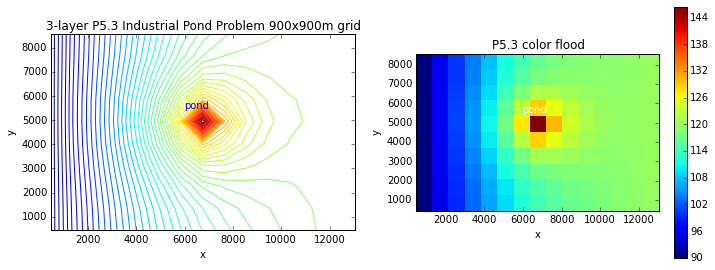

In [42]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(12,10))

#setup contour levels and plot extent
LEVELS = np.arange(90., 146., 1.)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 9000, 1000)
AX1.set_yticks(YTICKS)
AX1.set_title("3-layer P5.3 Industrial Pond Problem 900x900m grid")
AX1.text(6000, 5500, r"pond", fontsize=10, color="blue")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("P5.3 color flood")
AX2.text(6000, 5500, r"pond", fontsize=10, color="white")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)


In [43]:
#Using code from P4.4, let's again plot a cross section of head in row = 4 from headobj, recall that Python is zero based
#so that MODFLOW row 5 with the pond is equal to Python row 4
#define Y as HEAD along the row and then print; ROW is a variable that allows us to change the row plotted easily
ROW = 4
Y = HEAD[0,ROW,:]
print Y

[  90.           95.87985992  100.68195343  105.50688171  110.8824234
  117.56756592  127.24430847  146.39285278  130.09375     123.97592926
  121.32044983  120.21692657  119.85715485  119.85558319  120.        ]


In [44]:
#in order to plot the cross section we'll need to create X-coordinates to match with heads at the node centers
#(we could have just used the XCOORD calculated above as the X-Y spacing did not change, but we'll do it again
#to make sure we have the correct X coordinates)
XCOORD = np.arange(0, 13500, 900) + 450
print XCOORD

[  450  1350  2250  3150  4050  4950  5850  6750  7650  8550  9450 10350
 11250 12150 13050]


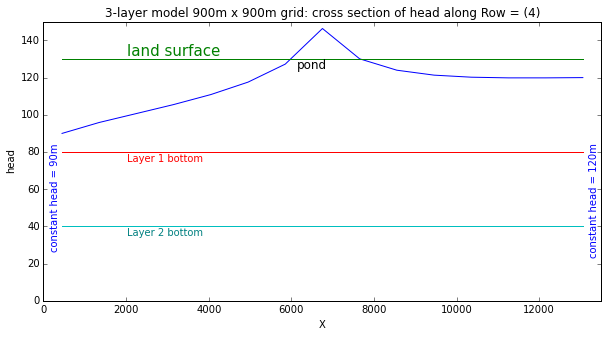

In [45]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  '3-layer model 900m x 900m grid: cross section of head along Row = ({0})'.format(ROW) #this allows the title to be updated as ROW changes
ax.set_title(TITLE)
ax.set_xlabel('X')
ax.set_ylabel('head')
ax.set_xlim(0, 13500.)
ax.set_ylim(0.,150.)
ax.text(6150,125, r"pond", fontsize=12, color="black")
ax.text(2030,132, r"land surface", fontsize=15, color="green")
ax.text(2030,75, r"Layer 1 bottom", fontsize=10, color="red")
ax.text(2030,35, r"Layer 2 bottom", fontsize=10, color="teal")
ax.text(13200, 80, r"constant head = 120m", fontsize=10, color="blue",rotation='vertical')
ax.text(150, 80, r"constant head = 90m", fontsize=10, color="blue",rotation='vertical')
ax.plot(XCOORD, Y)
ax.plot(XCOORD, XCOORD*0+130) #land surface
ax.plot(XCOORD, XCOORD*0+80) #Bottom of Layer 1
ax.plot(XCOORD, XCOORD*0+40) #Bottom of Layer 2

Examine your results and answer the following:

i. Explain why the results of the 2D model are different from the 3D model. What are the main factors that control the height of the water table mound under the pond? Discuss whether the 2D model is appropriate for this problem.

ii. Is it likely that the water table intersects the land surface away from the pond? If so, use shading on a map of the land surface in the vicinity of the pond to show the area affected by leakage.

## P5.3c
When the modeling report is sent out for review, reviewers question whether
the large nodal spacing of 900 m sufficiently captures the head gradient that
defines the mound. They say that the surface area affected by the mound is
underestimated. Use the three-layer model developed in (b) to assess the effect
of nodal spacing on the solution. Reduce the nodal spacing uniformly over
the grid/mesh to 300 m, or construct an irregular FD grid, unstructured FD
grid, or FE mesh with fine nodal spacing in the vicinity of the pond. Run the
model and generate equipotential maps for each layer (use a 1-m contour interval)
and a cross section that passes through the pond and constant head boundaries.
If the mound intersects the land surface, show the area impacted by shading
on a map of the land surface. Compare and contrast results with those of parts
(a) and (b).

In [46]:
# let's redefine the grid
LX = 12300.  # aquifer width of 11700 m + 2 300m nodes for constant head boundary condition on each end
LY = 9000.   # height of aquifer of 9000 m, no flow boundaries do not require explicit cells in MODFLOW
ZTOP = 130.  # the system is unconfined 
NROW = 30  #these two lines are the only things we need to change to refine 
NCOL = 41  # the grid
DELR = LX / NCOL  # recall that MODFLOW convention is DELR is along a row, thus has items = NCOL; see page XXX in AW&H (2015)
DELC = LY / NROW  # recall that MODFLOW convention is DELC is along a column, thus has items = NROW; see page XXX in AW&H (2015)
POND_SEEP=0.2
print "DELR =", DELR, "  DELC =", DELC
print "Pond Seepage =", POND_SEEP, "m/d"

DELR = 300.0   DELC = 300.0
Pond Seepage = 0.2 m/d


In [47]:
#repeat the modeling building steps from P5.3b to make sure all model definition is current
NLAY = 3
ZBOT = 0.
BOTM = np.zeros((NLAY, NROW, NCOL), dtype=np.float)
BOTM[0,:,:] = 80.
BOTM[1,:,:] = 40.
BOTM[2,:,:] = 0.
#print BOTM
# Create the discretization object
TOP = ZTOP * np.ones((NROW, NCOL),dtype=np.float)
DIS_PACKAGE = flopy.modflow.ModflowDis(MF, NLAY, NROW, NCOL, delr=DELR, delc=DELC,
                               top=TOP, botm=BOTM, laycbd=0)
IBOUND = np.ones((NLAY, NROW, NCOL), dtype=np.int)
IBOUND[:,:,0] = -1
IBOUND[:,:,-1] = -1
#print IBOUND
STRT = 130. * np.ones((NLAY, NROW, NCOL), dtype=np.float)
STRT[:,:,0] = 90.
STRT[:,:,-1] = 120.
#print STRT
BAS_PACKAGE = flopy.modflow.ModflowBas(MF, ibound=IBOUND, strt=STRT)
# print BAS_PACKAGE  # uncomment this at far left to see the information about the flopy BAS object
#Now we can assign the Kh for each layer from Figure P5.2
LAY1Kh=44.
LAY2Kh=0.13
LAY3Kh=113.
KH_ARRAY = np.zeros((NLAY, NROW, NCOL), dtype=np.float)
KH_ARRAY[0,:,:] = LAY1Kh
KH_ARRAY[1,:,:] = LAY2Kh
KH_ARRAY[2,:,:] = LAY3Kh
#print KH_ARRAY
#Now we can assign the Kv for each layer from Figure P5.2
LAY1Kv=4.4
LAY2Kv=0.013
LAY3Kv=11.3
KV_ARRAY = np.zeros((NLAY, NROW, NCOL), dtype=np.float)
KV_ARRAY[0,:,:] = LAY1Kv
KV_ARRAY[1,:,:] = LAY2Kv
KV_ARRAY[2,:,:] = LAY3Kv
#print KV_ARRAY
LPF_PACKAGE = flopy.modflow.ModflowLpf(MF, laytyp=1, hk=KH_ARRAY, vka=KV_ARRAY)  # we defined the K and anisotropy at top of file
# print LPF_PACKAGE  # uncomment this at far left to see the information about the flopy LPF object
#We have to place the pond in the new grid too via MODFLOW's Recharge Package (like in P5.3a)
SEEP_ARRAY = 0 * np.ones((NROW, NCOL), dtype=np.float32)  # set seepage to 0 over model grid
SEEP_ARRAY[12, 20] = POND_SEEP  # add Pond seepage at the pond location  (have 9 nodes now with finer grid)
SEEP_ARRAY[13, 20] = POND_SEEP 
SEEP_ARRAY[14, 20] = POND_SEEP 
SEEP_ARRAY[12, 21] = POND_SEEP 
SEEP_ARRAY[13, 21] = POND_SEEP 
SEEP_ARRAY[14, 21] = POND_SEEP 
SEEP_ARRAY[12, 22] = POND_SEEP 
SEEP_ARRAY[13, 22] = POND_SEEP 
SEEP_ARRAY[14, 22] = POND_SEEP 
RCH_PACKAGE = flopy.modflow.ModflowRch(MF, rech=SEEP_ARRAY)


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...


In [48]:
#Before writing input, destroy all files in folder to prevent reusing old files
#Here's the working directory
print modelpath
#Here's what's currently in the working directory
modelfiles = os.listdir(modelpath)
print modelfiles
#delete these files to prevent us from reading old results
modelfiles = os.listdir(modelpath)
for filename in modelfiles:
    f = os.path.join(modelpath, filename)
    if modelname in f:
        try:
            os.remove(f)
            print 'Deleted: ', filename
        except:
            print 'Unable to delete: ', filename

/Users/rjhunt1/GitHub/Chapter_5_problems-1/P5-3_Industrial_pond
['P5-3.bas', 'P5-3.cbc', 'P5-3.ddn', 'P5-3.dis', 'P5-3.hds', 'P5-3.list', 'P5-3.lpf', 'P5-3.nam', 'P5-3.oc', 'P5-3.pcg', 'P5-3.rch']
Deleted:  P5-3.bas
Deleted:  P5-3.cbc
Deleted:  P5-3.ddn
Deleted:  P5-3.dis
Deleted:  P5-3.hds
Deleted:  P5-3.list
Deleted:  P5-3.lpf
Deleted:  P5-3.nam
Deleted:  P5-3.oc
Deleted:  P5-3.pcg
Deleted:  P5-3.rch


In [49]:
#Now we are ready to write input and re-run MODFLOW with the 300 x 300 m grid
MF.write_input()
silent = False  #Print model output to screen?
pause = False   #Require user to hit enter? Doesn't mean much in Ipython notebook
report = True   #Store the output from the model in buff
success, buff = MF.run_model(silent=silent, pause=pause, report=report)

FloPy is using the following executable to run the model: /Users/rjhunt1/GitHub/Chapter_5_problems-1/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: P5-3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 15:37:50

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2015/09/23 15:37:50
 Elapsed run time:  0.110 Seconds

  Normal termination of simulation


In [50]:
#imports for plotting and reading the MODFLOW binary output file
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

#Create the headfile object and grab the results for last time.
headfile = os.path.join(modelpath, modelname + '.hds')
headfileobj = bf.HeadFile(headfile)

#Get a list of times that are contained in the model
times = headfileobj.get_times()
print 'Headfile (' + modelname + '.hds' + ') contains the following list of times: ', times

#Get a numpy array of heads for totim = 1.0
#The get_data method will extract head data from the binary file.
HEAD = headfileobj.get_data(totim=1.0)

#Print statistics on the head
print 'Head statistics'
print '  min: ', HEAD.min()
print '  max: ', HEAD.max()
print '  std: ', HEAD.std()

Headfile (P5-3.hds) contains the following list of times:  [1.0]
Head statistics
  min:  90.0
  max:  141.058
  std:  9.73142


Contour Levels:  [  90.   91.   92.   93.   94.   95.   96.   97.   98.   99.  100.  101.
  102.  103.  104.  105.  106.  107.  108.  109.  110.  111.  112.  113.
  114.  115.  116.  117.  118.  119.  120.  121.  122.  123.  124.  125.
  126.  127.  128.  129.  130.  131.  132.  133.  134.  135.  136.  137.
  138.  139.  140.  141.  142.  143.  144.  145.]
Extent of domain:  (150.0, 12150.0, 150.0, 8850.0)


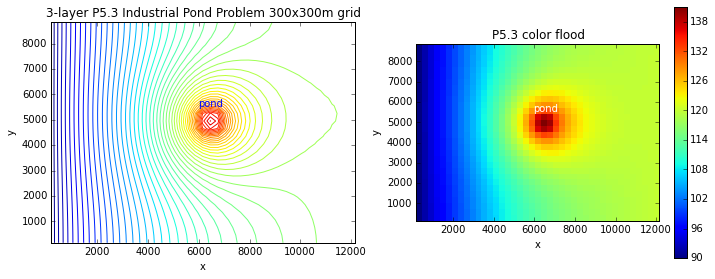

In [51]:
#Create a contour plot of heads
FIG = plt.figure(figsize=(12,10))

#setup contour levels and plot extent
LEVELS = np.arange(90., 146., 1.)
EXTENT = (DELR/2., LX - DELR/2., DELC/2., LY - DELC/2.)
print 'Contour Levels: ', LEVELS
print 'Extent of domain: ', EXTENT

#Make a contour plot on the first axis
AX1 = FIG.add_subplot(1, 2, 1, aspect='equal')
AX1.set_xlabel("x")
AX1.set_ylabel("y")
YTICKS = np.arange(0, 9000, 1000)
AX1.set_yticks(YTICKS)
AX1.set_title("3-layer P5.3 Industrial Pond Problem 300x300m grid")
AX1.text(6000, 5500, r"pond", fontsize=10, color="blue")
AX1.contour(np.flipud(HEAD[0, :, :]), levels=LEVELS, extent=EXTENT)

#Make a color flood on the second axis
AX2 = FIG.add_subplot(1, 2, 2, aspect='equal')
AX2.set_xlabel("x")
AX2.set_ylabel("y")
AX2.set_yticks(YTICKS)
AX2.set_title("P5.3 color flood")
AX2.text(6000, 5500, r"pond", fontsize=10, color="white")
cax = AX2.imshow(HEAD[0, :, :], extent=EXTENT, interpolation='nearest')
cbar = FIG.colorbar(cax, orientation='vertical', shrink=0.45)



In [52]:
#Using code from P4.4, let's look at the head in column = 13 from headobj, and then plot it
#print HEAD along a column; COL is a variable that allows us to change this easily
ROW = 13
Y = HEAD[0,ROW,:]
print Y

[  90.           92.20191956   94.10277557   95.84507751   97.49906158
   99.10613251  100.69413757  102.28421783  103.89440155  105.54179382
  107.24423218  109.02178955  110.89839172  112.90409088  115.07833099
  117.47544861  120.17428589  123.29616547  127.03907776  131.81721497
  138.65171814  141.05761719  139.5463562   133.59886169  129.82351685
  127.23197174  125.33682251  123.9227829   122.85611725  122.0485611
  121.43862152  120.9815979   120.6439209   120.39976501  120.22880554
  120.11479187  120.04445648  120.00672913  119.99217224  119.99246216
  120.        ]


In [53]:
#for our cross section create X-coordinates to match with heads
XCOORD = np.arange(0, 12300, 300) + 150
print XCOORD

[  150   450   750  1050  1350  1650  1950  2250  2550  2850  3150  3450
  3750  4050  4350  4650  4950  5250  5550  5850  6150  6450  6750  7050
  7350  7650  7950  8250  8550  8850  9150  9450  9750 10050 10350 10650
 10950 11250 11550 11850 12150]


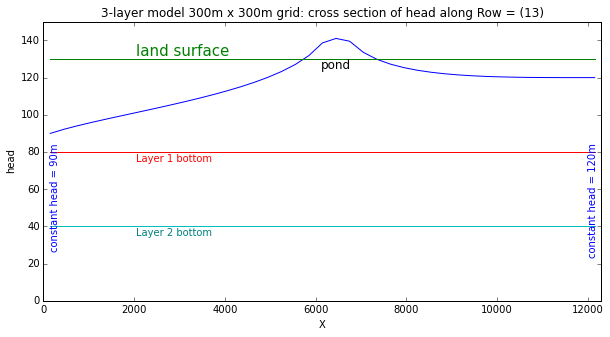

In [54]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
TITLE =  '3-layer model 300m x 300m grid: cross section of head along Row = ({0})'.format(ROW) #this allows the title to be updated as ROW changes
ax.set_title(TITLE)
ax.set_xlabel('X')
ax.set_ylabel('head')
ax.set_xlim(0, 12300.)
ax.set_ylim(0.,150.)
ax.text(6150,125, r"pond", fontsize=12, color="black")
ax.text(2030,132, r"land surface", fontsize=15, color="green")
ax.text(2030,75, r"Layer 1 bottom", fontsize=10, color="red")
ax.text(2030,35, r"Layer 2 bottom", fontsize=10, color="teal")
ax.text(12000, 80, r"constant head = 120m", fontsize=10, color="blue",rotation='vertical')
ax.text(150, 80, r"constant head = 90m", fontsize=10, color="blue",rotation='vertical')
ax.plot(XCOORD, Y)
ax.plot(XCOORD, XCOORD*0+130) #land surface
ax.plot(XCOORD, XCOORD*0+80) #Bottom of Layer 1
ax.plot(XCOORD, XCOORD*0+40) #Bottom of Layer 2

Compare and contrast results with those of parts (a) and (b).

## P5.3d
What is your conclusion about the cause of water-logging? Support your
answer with modeling results.

## P5.3e
In this problem we assumed that all parameters were known, and we examined
how layering (and anisotropy) and nodal spacing affected the height and
configuration of the water table. Make a list of factors (in addition to dimensionality
and nodal spacing) that would add uncertainty to a forecast of the
height of the water table mound in this problem. Speculate how the uncertainty
might affect modeling results and conclusions.